In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

In [2]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
len(os.listdir('../input/all-dogs/all-dogs'))

20579

In [4]:
fnames = glob.glob('../input/all-dogs/all-dogs/*.jpg')

In [5]:
len(fnames)

20579

In [6]:
print(fnames[0])

../input/all-dogs/all-dogs/n02085936_5545.jpg


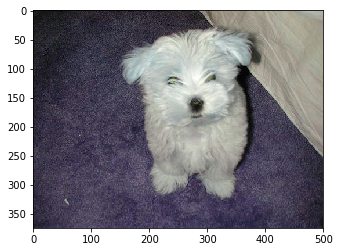

In [7]:
img = cv2.imread(fnames[0])
plt.imshow(img)
plt.show()

In [8]:
img.shape

(375, 500, 3)

In [9]:
ComputeLB = False
DogsOnly = True
# Constants and Directories
ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 


In [10]:
def load_images():
        idxIn = 0; namesIn = []
        imagesIn = np.zeros((25000,64,64,3))

        # CROP WITH BOUNDING BOXES TO GET DOGS ONLY
        # https://www.kaggle.com/paulorzp/show-annotations-and-breeds
        if DogsOnly:
            for breed in breeds:
                for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
                    try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
                    except: continue           
                    tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
                    root = tree.getroot()
                    objects = root.findall('object')
                    for o in objects:
                        bndbox = o.find('bndbox') 
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        w = np.min((xmax - xmin, ymax - ymin))
                        img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                        img2 = img2.resize((64,64), Image.ANTIALIAS)
                        imagesIn[idxIn,:,:,:] = np.asarray(img2)
                        #if idxIn%1000==0: print(idxIn)
                        namesIn.append(breed)
                        idxIn += 1
            idx = np.arange(idxIn)
            np.random.shuffle(idx)
            imagesIn = imagesIn[idx,:,:,:]
            namesIn = np.array(namesIn)[idx]

        # RANDOMLY CROP FULL IMAGES
        else:
            x = np.random.choice(np.arange(20579),10000)
            for k in range(len(x)):
                img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
                w = img.size[0]
                h = img.size[1]
                sz = np.min((w,h))
                a=0; b=0
                if w<h: b = (h-sz)//2
                else: a = (w-sz)//2
                img = img.crop((0+a, 0+b, sz+a, sz+b))  
                img = img.resize((64,64), Image.ANTIALIAS)   
                imagesIn[idxIn,:,:,:] = np.asarray(img)
                namesIn.append(IMAGES[x[k]])
                if idxIn%1000==0: print(idxIn)
                idxIn += 1
        return imagesIn

In [11]:
images = load_images()
'''for f in tqdm_notebook(fnames):
    img = cv2.imread(f)
    img = cv2.resize(img,(64,64))
    images.append(img)'''

'for f in tqdm_notebook(fnames):\n    img = cv2.imread(f)\n    img = cv2.resize(img,(64,64))\n    images.append(img)'

In [12]:
images /= 255

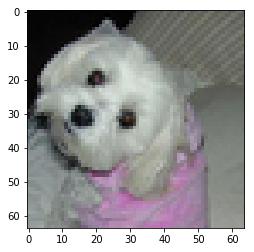

In [13]:
plt.imshow(images[0])
plt.show()

In [14]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  
  hid = Dense(256 * 32 * 32, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((32, 32, 256))(hid)

  hid = Conv2D(256, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(256, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(256, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(256, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [15]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [16]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [17]:
# GAN creation
img_input = Input(shape=(64,64,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer='sgd', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
__________

In [18]:
BATCH_SIZE = 64
'''
# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Select Cars
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))
'''
#X_train = np.array(images)
# Normalize data
#X_train = (X_train - 127.5) / 127.5
 
num_batches = int(images.shape[0]/BATCH_SIZE)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


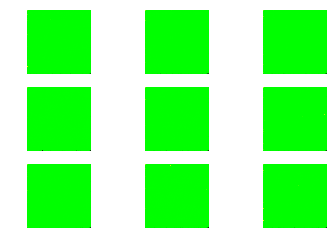

  Epoch: 1, Generator Loss: 9.371502398888486, Discriminator Loss: [0.7141575 0.       ]
  Epoch: 2, Generator Loss: 3.107352466168611, Discriminator Loss: [0.36189938 0.        ]
  Epoch: 3, Generator Loss: 2.95109281539917, Discriminator Loss: [0.3525268 0.       ]
  Epoch: 4, Generator Loss: 2.7057840395664825, Discriminator Loss: [0.33036324 0.        ]
  Epoch: 5, Generator Loss: 2.9656893729731655, Discriminator Loss: [0.4130422 0.       ]


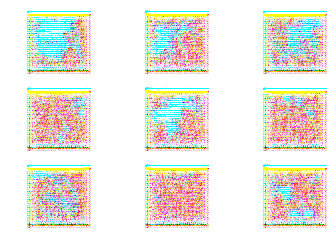

  Epoch: 6, Generator Loss: 2.870913841067881, Discriminator Loss: [0.34384584 0.        ]
  Epoch: 7, Generator Loss: 2.7307363105856854, Discriminator Loss: [0.33222577 0.        ]
  Epoch: 8, Generator Loss: 2.5875485005586043, Discriminator Loss: [0.31768367 0.        ]
  Epoch: 9, Generator Loss: 2.5873599397963374, Discriminator Loss: [0.318345 0.      ]
  Epoch: 10, Generator Loss: 2.544649917146434, Discriminator Loss: [0.31661618 0.        ]


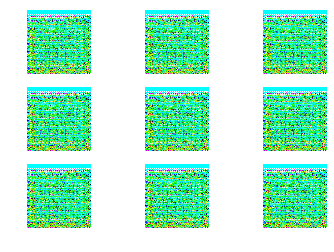

  Epoch: 11, Generator Loss: 2.545961284291917, Discriminator Loss: [0.3149878 0.       ]
  Epoch: 12, Generator Loss: 2.5267870885738426, Discriminator Loss: [0.3131873 0.       ]
  Epoch: 13, Generator Loss: 2.4865928577340166, Discriminator Loss: [0.31309912 0.        ]
  Epoch: 14, Generator Loss: 2.469481114719225, Discriminator Loss: [0.3122803 0.       ]
  Epoch: 15, Generator Loss: 2.4639417942019475, Discriminator Loss: [0.3102771 0.       ]


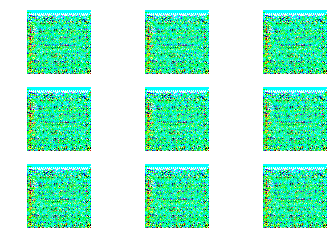

  Epoch: 16, Generator Loss: 2.466728300633638, Discriminator Loss: [0.31146637 0.        ]
  Epoch: 17, Generator Loss: 2.5491341089856796, Discriminator Loss: [0.31506503 0.        ]
  Epoch: 18, Generator Loss: 2.482726459917815, Discriminator Loss: [0.31161934 0.        ]
  Epoch: 19, Generator Loss: 2.4909221210341523, Discriminator Loss: [0.31115153 0.        ]
  Epoch: 20, Generator Loss: 2.511153370746668, Discriminator Loss: [0.31141168 0.        ]


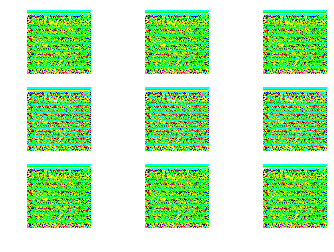

  Epoch: 21, Generator Loss: 2.4667074338249537, Discriminator Loss: [0.31104377 0.        ]
  Epoch: 22, Generator Loss: 2.4607828437418178, Discriminator Loss: [0.31039426 0.        ]
  Epoch: 23, Generator Loss: 2.4662940578184265, Discriminator Loss: [0.31068185 0.        ]
  Epoch: 24, Generator Loss: 2.455176334104676, Discriminator Loss: [0.31005484 0.        ]
  Epoch: 25, Generator Loss: 2.454336708870487, Discriminator Loss: [0.3098649 0.       ]


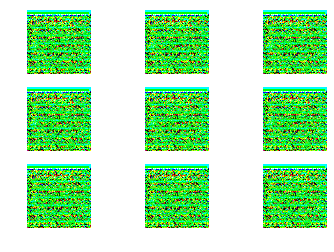

  Epoch: 26, Generator Loss: 2.4485006284022677, Discriminator Loss: [0.30914104 0.        ]
  Epoch: 27, Generator Loss: 2.4381612459818522, Discriminator Loss: [0.30906528 0.        ]
  Epoch: 28, Generator Loss: 2.4300313375998233, Discriminator Loss: [0.30982408 0.        ]
  Epoch: 29, Generator Loss: 2.4391167619953986, Discriminator Loss: [0.30864108 0.        ]
  Epoch: 30, Generator Loss: 2.4259372255076532, Discriminator Loss: [0.30991554 0.        ]


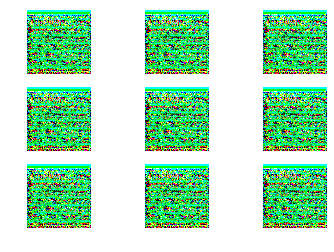

  Epoch: 31, Generator Loss: 2.432366922627325, Discriminator Loss: [0.3094098 0.       ]
  Epoch: 32, Generator Loss: 2.4815024932225547, Discriminator Loss: [0.31214678 0.        ]
  Epoch: 33, Generator Loss: 2.4684978941212528, Discriminator Loss: [0.30934027 0.        ]
  Epoch: 34, Generator Loss: 2.4613778148872263, Discriminator Loss: [0.31030208 0.        ]
  Epoch: 35, Generator Loss: 2.4521297109299813, Discriminator Loss: [0.30957317 0.        ]


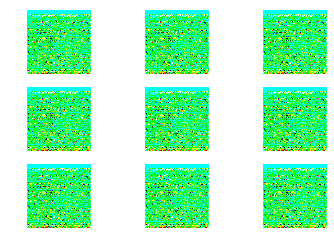

  Epoch: 36, Generator Loss: 2.4343352421470312, Discriminator Loss: [0.30889106 0.        ]
  Epoch: 37, Generator Loss: 2.4385479415672413, Discriminator Loss: [0.308439 0.      ]
  Epoch: 38, Generator Loss: 2.4464122447414676, Discriminator Loss: [0.30794892 0.        ]
  Epoch: 39, Generator Loss: 2.4367767340895057, Discriminator Loss: [0.30876017 0.        ]
  Epoch: 40, Generator Loss: 2.427292225326317, Discriminator Loss: [0.30918923 0.        ]


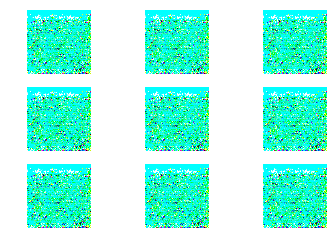

  Epoch: 41, Generator Loss: 2.432368297162263, Discriminator Loss: [0.30898944 0.        ]
  Epoch: 42, Generator Loss: 2.4359640777974887, Discriminator Loss: [0.30932206 0.        ]
  Epoch: 43, Generator Loss: 2.4316648559293883, Discriminator Loss: [0.3078522 0.       ]
  Epoch: 44, Generator Loss: 2.427003296561863, Discriminator Loss: [0.30815554 0.        ]
  Epoch: 45, Generator Loss: 2.424172791881838, Discriminator Loss: [0.3090459 0.       ]


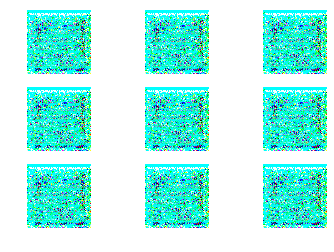

  Epoch: 46, Generator Loss: 2.4387053061222685, Discriminator Loss: [0.3076998 0.       ]
  Epoch: 47, Generator Loss: 2.4437576045160707, Discriminator Loss: [0.30936226 0.        ]
  Epoch: 48, Generator Loss: 2.440983055639958, Discriminator Loss: [0.3089927 0.       ]
  Epoch: 49, Generator Loss: 2.463734805756721, Discriminator Loss: [0.30951214 0.        ]
  Epoch: 50, Generator Loss: 2.465587995060976, Discriminator Loss: [0.31611568 0.        ]


In [19]:
N_EPOCHS = 50
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    imgs = images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(imgs, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
  if epoch%5 == 0:
    show_imgs("epoch" + str(epoch)) 
  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))

In [20]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((100))
        xx[self.index] = 0.999
        xx[np.random.randint(100)] = 0.001
        img = generator.predict(xx.reshape((-1,100)))[0].reshape((64,64,3))
        self.index = (self.index+1)%100
        return Image.fromarray( img.astype('uint8') ) 

In [21]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in tqdm_notebook(range(10000)):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()